In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
# 读入待处理视频文件, 并将每一帧图像保存在frames列表中
cap = cv2.VideoCapture('视频处理/花海.mkv')
frames = []
while cap.isOpened():
    ret, frame = cap.read() 
    if not ret:
        break
    frames.append(frame)
cap.release() 

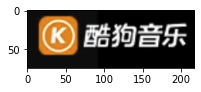

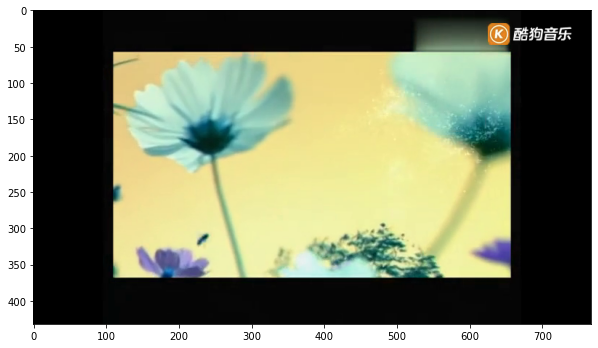

In [7]:
# 读入logo文件并将其展示
logo = cv2.imread('视频处理/kugou.png')
img1 = cv2.cvtColor(logo, cv2.COLOR_RGB2BGR)
img2 = frames[50].copy()
plt.figure(figsize=(3,6))
plt.imshow(logo)
plt.figure(figsize=(10,20))
plt.imshow(img2)

In [8]:
# 返回ROI(水印在图像中矩阵)四个顶点
def findWaterMark(img1, img2, MIN_MATCH_COUNT = 8):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN参数
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    # 现在我们设置一个条件，即至少有10个匹配项（由MIN_MATCH_COUNT定义）可以找到对象。否则，只需显示一条消息，说明没有足够的匹配项。
    if len(good)>MIN_MATCH_COUNT:
        # 获取关键点的坐标
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # matchesMask = mask.ravel().tolist()
        h,w,d = img1.shape
        # 使用得到的变换矩阵对原图像的四个角进行变换，获得在目标图像上对应的坐标
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        roidst = cv2.perspectiveTransform(pts,M)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        # matchesMask = None
        return None
    return roidst

In [9]:
# 根据roidst四个顶点对水印模板进行投影变换, 然后对图像进行修复
def fix(img1, img2, roidst, threshold = 120):
    # 根据roidst区域大小制作掩码
    by = int(roidst[0][0][0])
    bx = int(roidst[0][0][1])
    width = int(roidst[1][0][1] - bx)
    height = int(roidst[2][0][0] - by)
    # print(bx,by,height,width)
    # 计算得到ROI
    roi = img2[bx : width + bx, by : height + by]
    # 得到变换后的水印模板
    res = cv2.resize(img1,(height, width))
    resgray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
    # 得到mask, 像素值小于threshold的全设为黑0, 大于的设为白255
    ret, mask = cv2.threshold(resgray, threshold, 255, cv2.THRESH_BINARY)
    # 将灰度值mask变为BGR格式用于得到膨胀mask
    img1_fg = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    #OpenCV定义的结构元素, 用于膨胀图像
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    # 膨胀img1_fg图像
    dilated = cv2.dilate(img1_fg,kernel)
    # 得到膨胀mask图像
    dilatedmask = cv2.cvtColor(dilated, cv2.COLOR_RGB2GRAY)
    # 利用mask对图像进行修复
    roidst2 = cv2.inpaint(roi, dilatedmask,5,flags=cv2.INPAINT_TELEA)
    img2[bx : width + bx, by : height + by] = roidst2
    return img2

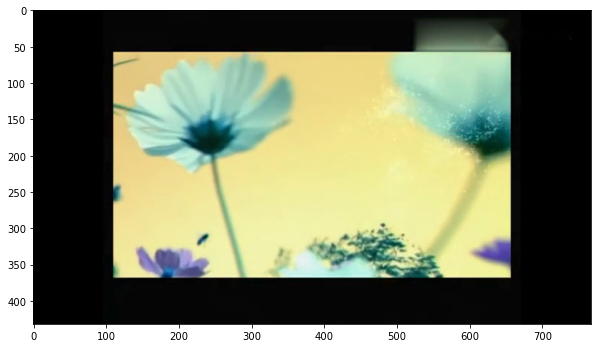

In [27]:
# test findWaterMark and fix function
# img2 = frames[50].copy()
roidst = findWaterMark(img1, img2)
res = fix(img1, img2.copy(), roidst)
plt.figure(figsize= (10,20))
plt.imshow(res)

In [24]:
# 对每一帧图像进行水印去除工作, 并将结果全部保存在frames1列表中
frames1 = []
# 由于本测试视频中每一帧的水印位置是相同的, 因此只进行了一次位置匹配
img2 = frames[50].copy()
# 水印模板中水印与图像中水印进行匹配, 得到水印在图像中所处位置的四个顶点roidst
roidst = findWaterMark(img1, img2)
for i in range(len(frames)):
    img2 = frames[i].copy()
    # fix方法返回去水印后的图像
    res = fix(img1, img2.copy(), roidst)
    frames1.append(res)

6623


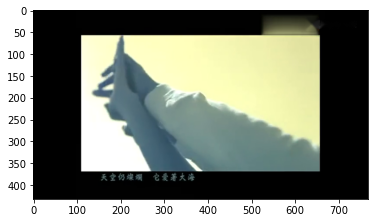

In [28]:
# test
print(len(frames1))
plt.imshow(frames1[5622])

for i in range(10, len(frames1)):
    cv2.imshow('花海',frames1[i])
    cv2.waitKey()
cv2.destroyAllWindows()

In [43]:
# 将处理好的图片存入视频流, 并保存为output.avi文件
cap = cv2.VideoCapture('视频处理/花海.mkv')
fps = cap.get(cv2.CAP_PROP_FPS) 
print(fps) 
# 获取cap视频流的每帧大小 
size=(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) 
print(size)
fourcc = cv2.VideoWriter_fourcc(*'MP42')
out = cv2.VideoWriter('视频处理/output.avi', fourcc, fps, size)
for frame in frames1:
    out.write(frame)
out.release()
cap.release()

25.0
(768, 432)


In [44]:
# 由于上述操作没有提取音频, 现在引用moviepy库来提取音频并添加到视频中
from moviepy.editor import *
videoclip1 = VideoFileClip("视频处理/花海.mkv")
videoclip2 = VideoFileClip("视频处理/output.avi")

audio1 = videoclip1.audio
videoclip3 = videoclip2.set_audio(audio1)

videoclip3.write_videofile('视频处理/output1.mp4')

chunk:   0%|          | 28/5842 [00:00<00:25, 226.90it/s, now=None]Moviepy - Building video output1.mp4.
MoviePy - Writing audio in output1TEMP_MPY_wvf_snd.mp3
t:   0%|          | 3/6623 [00:00<04:52, 22.60it/s, now=None]MoviePy - Done.
Moviepy - Writing video output1.mp4

Moviepy - Done !
Moviepy - video ready output1.mp4
